# Import libraries and dataframe

In [1]:
import numpy as np
import pandas as pd


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score
from sklearn.metrics import plot_confusion_matrix
from scoring_functions import scoring_functions as f
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline

# imp allows to reload the above function file when tinkering with it without kernel restart
import imp

import time
import matplotlib.pyplot as plt

In [2]:
# read datafile
df = pd.read_csv('../project_data/complaints_processed.csv')

# clean up by removing NaN's, etc.
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df = df.dropna()
df.drop(df.loc[df['narrative'] == 'name'].index, inplace=True)

# replace class names with integers
product_dict ={'credit_reporting': 0, 'debt_collection': 1, 'mortgages_and_loans': 2, 
               'credit_card': 3, 'retail_banking': 4}
df['product'].replace(product_dict, inplace=True)

In [3]:
df.shape

(162405, 2)

## Train-test split

In [3]:
X = df.drop(['product'], axis=1)
y = df['product']

X_train, X_test, y_train, y_test = train_test_split(X['narrative'], y, test_size=0.20, random_state=200)

# Decision Tree

## Pipeline 1

- get idea on what limiting TF-IDF does to performance
- get idea on what max depth does to performance

In [5]:
dt1_pipeline = Pipeline([('tfidf', TfidfVectorizer()), 
                         ('dt', DecisionTreeClassifier(random_state=123))])

In [6]:
dt1_param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_features': [5000, 10000, 25000], 
    'dt__max_depth': [2, 4, 6]
}

In [7]:
dt1_grid_search = GridSearchCV(estimator=dt1_pipeline,
                               param_grid=dt1_param_grid,
                               scoring='recall_macro',
                               cv=3)

In [8]:
dt1_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=123))]),
             param_grid={'dt__max_depth': [2, 4, 6],
                         'tfidf__max_features': [5000, 10000, 25000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='recall_macro')

The above cell took 56 minutes to run.

In [9]:
dt1_grid_search.best_params_

{'dt__max_depth': 6,
 'tfidf__max_features': 10000,
 'tfidf__ngram_range': (1, 1)}

In [10]:
dt1_grid_search.best_score_

0.6282982397618458

Seeing how CountVectorizer will compare with TF-IDF

## Pipeline 2

In [11]:
dt2_pipeline = Pipeline([('countv', CountVectorizer()), 
                         ('dt', DecisionTreeClassifier(random_state=123))])

dt2_param_grid = {
    'countv__ngram_range': [(1,1), (1,2)],
    'countv__max_features': [5000, 10000, 25000], 
    'dt__max_depth': [6]
}

dt2_grid_search = GridSearchCV(estimator=dt2_pipeline,
                               param_grid=dt2_param_grid,
                               scoring='recall_macro',
                               cv=3)

In [12]:
dt2_grid_search.fit(X_train, y_train)
print(f'Best Score: {round(dt2_grid_search.best_score_, 3)}')
dt2_grid_search.best_params_

Best Score: 0.62


{'countv__max_features': 5000,
 'countv__ngram_range': (1, 1),
 'dt__max_depth': 6}

The above cell took 11 minutes to run.

In [15]:
print(f'Best Score: {round(dt2_grid_search.best_score_, 3)}')

Best Score: 0.621


- TFIDF did a smidgen better than CountVectorizer -- 0.628 vs. 0.621
- TFIDF did better with 10000 max features, and CountVectorizer did best with 5000 max features  
- Both did better with n_gram range: (1,1)  

Will try to refine max features with TFIDF

## Pipeline 3

In [20]:
dt3_pipeline = Pipeline([('tfidf', TfidfVectorizer()), 
                         ('dt', DecisionTreeClassifier(random_state=123))])

dt3_param_grid = {
    'tfidf__max_features': [7000, 10000, 12500, 16000], 
    'dt__max_depth': [6]
}

dt3_grid_search = GridSearchCV(estimator=dt3_pipeline,
                               param_grid=dt3_param_grid,
                               scoring='recall_macro',
                               cv=3)

In [21]:
dt3_grid_search.fit(X_train, y_train)
print(f'Best Score: {round(dt3_grid_search.best_score_, 3)}')
dt3_grid_search.best_params_

Best Score: 0.628


{'dt__max_depth': 6, 'tfidf__max_features': 10000}

It seems like 10000 features is the sweet spot.

For TFIDF, I'll go with `max_features=10000`, and `n_gram_range = (1,1)`, which is default.

## Pipeline 4

In [22]:
dt4_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=10000)), 
                         ('dt', DecisionTreeClassifier(random_state=123))])

dt4_param_grid = {
    'dt__max_depth': [6, 10, 14],    
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 3, 5]}

dt4_grid_search = GridSearchCV(estimator=dt4_pipeline,
                               param_grid=dt4_param_grid,
                               scoring='recall_macro',
                               cv=3)

In [23]:
dt4_grid_search.fit(X_train, y_train)
print(f'Best Score: {round(dt4_grid_search.best_score_, 4)}')
dt4_grid_search.best_params_

Best Score: 0.7182


{'dt__max_depth': 14, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 5}

I got my score up to 0.72 from a baseline of 0.62.

## Check best-scoring model for overfitting 

In [10]:
# Vectorize X train and test data
vectorizer_dt_best = TfidfVectorizer(max_features=10000)
vect_X_train = vectorizer_dt_best.fit_transform(X_train)
vect_X_test = vectorizer_dt_best.transform(X_test)
feature_names =  vectorizer_dt_best.get_feature_names()

In [8]:
# Instantiate model
dt_best = DecisionTreeClassifier(
    random_state=123,
    max_depth=14,
    min_samples_leaf=1,
    min_samples_split=5)

TRAINING - Classification Report
Accuracy: 84.9%
Precision: 82.4%
Recall: 77.9%
F1: 80.0%
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     73012
           1       0.81      0.68      0.74     18544
           2       0.84      0.77      0.80     15180
           3       0.77      0.72      0.75     12364
           4       0.83      0.79      0.81     10824

    accuracy                           0.85    129924
   macro avg       0.82      0.78      0.80    129924
weighted avg       0.85      0.85      0.85    129924

TESTING - Classification Report
Accuracy: 80.9%
Precision: 76.7%
Recall: 72.5%
F1: 74.4%
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     18159
           1       0.75      0.62      0.68      4601
           2       0.78      0.72      0.75      3810
           3       0.70      0.64      0.67      3200
           4       0.76      0.72      0.74      2711

    ac

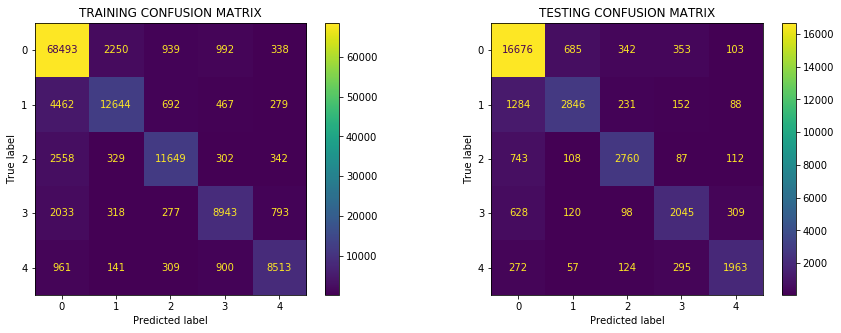

In [12]:
imp.reload(f)
f.run_model(dt_best, vect_X_train, y_train, vect_X_test, y_test)

Not perfect but pretty good results. It seems debt_collection (category 1) is the hardest for the model to fit.

# Naive Bayes

## Pipeline 1

- get idea on what limiting TF-IDF does to performance
- get idea on what smoothing does to performance

In [14]:
nb1_pipeline = Pipeline([('tfidf', TfidfVectorizer()), 
                         ('nb', MultinomialNB())])

In [21]:
nb1_param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_features': [5000, 10000, 25000]
}

In [22]:
nb1_grid_search = GridSearchCV(estimator=nb1_pipeline,
                               param_grid=nb1_param_grid,
                               scoring='recall_macro',
                               cv=3)

In [23]:
nb1_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tfidf__max_features': [5000, 10000, 25000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='recall_macro')

In [24]:
nb1_grid_search.best_params_

{'tfidf__max_features': 25000, 'tfidf__ngram_range': (1, 2)}

In [26]:
round(nb1_grid_search.best_score_, 3)

0.826

## Pipeline 2

In [29]:
nb2_pipeline = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))), 
                         ('nb', MultinomialNB())])

In [30]:
nb2_param_grid = {
    'tfidf__max_features': [25000, 40000, 55000],
    'nb__alpha': [.7, 1.3]
}

In [31]:
nb2_grid_search = GridSearchCV(estimator=nb2_pipeline,
                               param_grid=nb2_param_grid,
                               scoring='recall_macro',
                               cv=3)

In [32]:
nb2_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__alpha': [0.7, 1.3],
                         'tfidf__max_features': [25000, 40000, 55000]},
             scoring='recall_macro')

In [33]:
print(f'Best Score: {round(nb2_grid_search.best_score_, 4)}')
nb2_grid_search.best_params_

Best Score: 0.8299


{'nb__alpha': 0.7, 'tfidf__max_features': 40000}

A little better score. I think the lower alpha might help with overfitting, too.

## Pipeline 3

Try out CountVectorizer

In [35]:
nb3_pipeline = Pipeline([('countv', CountVectorizer()), 
                         ('nb', MultinomialNB())])

nb3_param_grid = {
    'countv__ngram_range': [(1,1), (1,2)],
    'countv__max_features': [10000, 25000, 40000], 
    'nb__alpha': [0.7, 1]
}

nb3_grid_search = GridSearchCV(estimator=nb3_pipeline,
                               param_grid=nb3_param_grid,
                               scoring='recall_macro',
                               cv=3)

In [36]:
nb3_grid_search.fit(X_train, y_train)
print(f'Best Score: {round(nb3_grid_search.best_score_, 4)}')
nb3_grid_search.best_params_

Best Score: 0.8314


{'countv__max_features': 40000,
 'countv__ngram_range': (1, 2),
 'nb__alpha': 0.7}

## Pipeline 4

Count vectorizer did a little better. I'll also try with SMOTE. Raise max features, and lower alpha

In [40]:
# Need this imblearn pipeline to work with SMOTE
from imblearn.pipeline import Pipeline as imblearnPipeline

nb4_pipeline = imblearnPipeline([('countv', CountVectorizer(ngram_range=(1,2))),
                                 ('sampling', SMOTE()),
                                 ('nb', MultinomialNB())])

nb4_param_grid = {
    'countv__max_features': [40000, 55000], 
    'nb__alpha': [0.55, 0.7]
}

nb4_grid_search = GridSearchCV(estimator=nb4_pipeline,
                               param_grid=nb4_param_grid,
                               scoring='recall_macro',
                               cv=3)

In [41]:
nb4_grid_search.fit(X_train, y_train)
print(f'Best Score: {round(nb4_grid_search.best_score_, 4)}')
nb4_grid_search.best_params_

Best Score: 0.8279


{'countv__max_features': 55000, 'nb__alpha': 0.55}

Actually did a little worse with SMOTE. The model seems to prefer higher max features and lower alphas.

## Pipeline 5

Seems my scores are topping out around .82 or .83. I'll try one more time.

In [42]:
nb5_pipeline = imblearnPipeline([('countv', CountVectorizer(ngram_range=(1,2))),
                                 ('nb', MultinomialNB())])

nb5_param_grid = {
    'countv__max_features': [55000, 70000], 
    'nb__alpha': [0.45, 0.55]
}

nb5_grid_search = GridSearchCV(estimator=nb5_pipeline,
                               param_grid=nb5_param_grid,
                               scoring='recall_macro',
                               cv=3)

In [43]:
nb5_grid_search.fit(X_train, y_train)
print(f'Best Score: {round(nb5_grid_search.best_score_, 4)}')
nb5_grid_search.best_params_

Best Score: 0.8364


{'countv__max_features': 70000, 'nb__alpha': 0.45}

Got up to a score of almost .84. Will use these parameters.

## Check best-scoring model for overfitting 

In [44]:
# Vectorize X train and test data
vectorizer_nb_best = CountVectorizer(ngram_range=(1,2), max_features=70000)
vect_X_train = vectorizer_nb_best.fit_transform(X_train)
vect_X_test = vectorizer_nb_best.transform(X_test)
feature_names = vectorizer_nb_best.get_feature_names()

In [45]:
# Instantiate model
nb_best = MultinomialNB(alpha=0.45)

TRAINING - Classification Report
Accuracy: 82.8%
Precision: 76.6%
Recall: 85.7%
F1: 80.3%
              precision    recall  f1-score   support

           0       0.96      0.80      0.87     73012
           1       0.71      0.79      0.75     18544
           2       0.70      0.91      0.79     15180
           3       0.64      0.85      0.73     12364
           4       0.81      0.94      0.87     10824

    accuracy                           0.83    129924
   macro avg       0.77      0.86      0.80    129924
weighted avg       0.85      0.83      0.83    129924

TESTING - Classification Report
Accuracy: 81.3%
Precision: 74.7%
Recall: 83.4%
F1: 78.2%
              precision    recall  f1-score   support

           0       0.96      0.80      0.87     18159
           1       0.71      0.77      0.73      4601
           2       0.68      0.89      0.77      3810
           3       0.61      0.81      0.70      3200
           4       0.78      0.91      0.84      2711

    ac

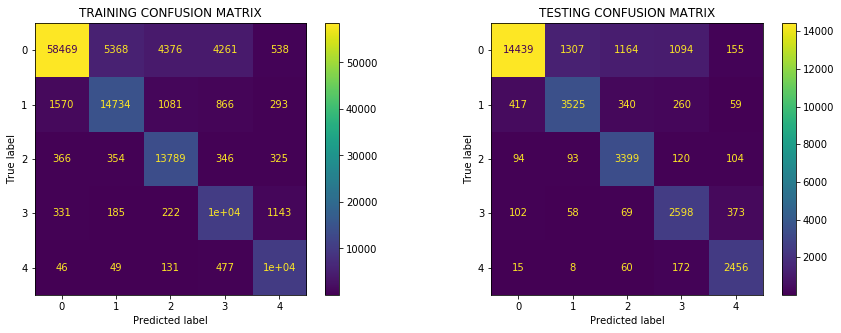

In [46]:
f.run_model(nb_best, vect_X_train, y_train, vect_X_test, y_test)

Pretty good. Performed better than Decision Tree.

# Gradient Boosting

## Pipeline 1

Best params for standard Decision Tree were:
- TfidfVectorizer(max_features=10000)
- max_depth=14
- min_samples_leaf=1
- min_samples_split=5

In [4]:
gb1_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=10000)), 
                         ('gb', GradientBoostingClassifier(random_state=123, 
                                                           verbose=1))])

gb1_param_grid = {
#     'tfidf__max_features': [7000, 10000, 12500], 
    'gb__max_depth': [10, 18]
#     'gb__learning_rate': [.1, .3]
}

gb1_grid_search = GridSearchCV(estimator=gb1_pipeline,
                               param_grid=gb1_param_grid,
                               scoring='recall_macro',
                               cv=3)

In [5]:
gb1_grid_search.fit(X_train, y_train)
print(f'Best Score: {round(gb1_grid_search.best_score_, 3)}')
gb1_grid_search.best_params_

      Iter       Train Loss   Remaining Time 
         1           1.0603          139.73m
         2           0.9298          138.78m
         3           0.8347          133.75m
         4           0.7601          130.32m
         5           0.6980          129.39m
         6           0.6481          128.42m
         7           0.6048          128.28m
         8           0.5678          125.13m
         9           0.5346          121.89m
        10           0.5068          118.66m
        20           0.3515           85.44m
        30           0.2867           66.48m
        40           0.2516           55.96m
        50           0.2286           43.70m
        60           0.2126           33.19m
        70           0.2012           24.99m
        80           0.1933           16.10m
        90           0.1869            7.71m
       100           0.1818            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.0602           84.69m
        

{'gb__max_depth': 10}